# 5a. Radiation Transport (RT) Solvers

## 5.0 Fundamental concepts and equations

The fundamental equation we will be using and solving is

\begin{equation}\tag{1}
\frac{d I_{\Omega,\nu}(\tau)}{d \tau_{\nu}} = I_{\Omega,\nu}(\tau_{\Omega,\nu}) - S_{\Omega,\nu}(\tau_{\Omega,\nu}) \,,
\end{equation}

where $I_{\Omega,\nu}(\tau)$ is the ___specific radition intensity___ (energy per unit area, time, and frequency interval; e.g. Watt per square meter and Hertz) at frequency $\nu$ in the direction $\Omega$, $S_{\Omega,\nu}(\tau)$ is the corresponding ___source funtion___ (same units), and $d\tau$ is the ___optical deptht increment___

\begin{equation}\tag{2}
d\tau_{\nu} = \rho\kappa_{\nu} ds \,,
\end{equation}

where $ds$ is an length interval along a "ray" of light in the direction $-\Omega$, $\rho$ is the mass density, and $\kappa_{\nu}$ is the ___opacity___ (in area-per-unit-mass) at frequency $\nu$.  

The Python package `radiation.py`, discussed in `Radiation.ipynb`, can supply source function values. Opacity values are normally given by table lookup (such as the *OPAL project* for stellar interiors), but in this weeks exercise, we will only use simple approximations or constant values.

Note that, by convention, the optical depth is counted in the direction opposite to the direction of propagation, and therefore the absorption of light is represented by a _positive_ term, and the emission of light by a _negative_ term.

Instead of the frequency $\nu$ one can instead use the ___wavelength___

\begin{equation}\tag{3}
\lambda = \frac{c}{\nu}\,.
\end{equation}

Since, in this context, $\Omega$ and $\nu$ are just "indices", which enumerate various cases, we may as well drop them, and write  

\begin{equation}\tag{4}
\frac{d I}{d \tau} = I - S \,,
\end{equation}

## 5.1 The Feautrier formalism

The ___Feautrier method___ is both a technique for solving Eq. (4), which also gives immediate and useful insight into some fundamental properties of the solutions, and therefore we start with that.   The idea is to combine the equations for light going in opposite directions, while counting optical depth always in the same direction.  Writing $I^-$ for the "outgoing" direction (opposite to the direction in which $\tau$ increases) and $I^+$ for the intensity in the "incoming" direction, we have

\begin{equation}\tag{5}
\frac{d I^-}{d \tau} = I^- - S \,,
\end{equation}

\begin{equation}\tag{6}
\frac{d I^+}{d \tau} = -I^+ + S \,,
\end{equation}

Taking the average sum and difference, and defining

\begin{equation}\tag{7}
P = \frac{1}{2} (I^++ I^-) \,,
\end{equation}

\begin{equation}\tag{8}
R = \frac{1}{2} (I^+ - I^-) \,,
\end{equation}

we get these equations for $P$ and $R$:

\begin{equation}\tag{9}
\frac{d P}{d\tau} = R \,,
\end{equation}


\begin{equation}\tag{10}
\frac{d R}{d\tau} = P-S \,,
\end{equation}

which may be combined into a 2nd order ("Feautrier") differential equation for $P$:

\begin{equation}\tag{11}
\frac{d^2 P}{d\tau^2} = P-S \,.
\end{equation}

Since we are often more interested in the _net_ difference between the intensity and the source function, it may also be useful to make the definition

\begin{equation}\tag{12}
Q = P-S \,,
\end{equation}

which when substututed into Eq. 11 yields

\begin{equation}\tag{13}
\frac{d^2 Q}{d\tau^2} = Q -  \frac{d^2 S}{d\tau^2}\,.
\end{equation}

If the _net intensity_, or _heating rate_, $Q$ is systematically smaller than $S$ over an interval of $\tau$, we can immediately deduce a limiting solution,

\begin{equation}\tag{14}
Q =  \frac{d^2 S}{d\tau^2}\,.
\end{equation}

From other arguments (basically just looking at Eq. 11) we understand that $I$ is very close to $S$ at large optical depth, so in such a regimen Eq. 14 is asymtotically accurate, and only requires evaluating a local 2nd derivative of S.

We may also draw another conclusion from Eq. 14; namely, that if we are only interested in the _net intensity_ (which is all we need to compute radiative cooling and heating), then we actually don't need the source function $S$ itself, but only its 2nd order derivative along the line of sight.  And at the boundaries, what we need is apparently only $Q$ (although we may actually get it from knowing both $I$ and $S$).

## 5.2 Solution methods and Python optimization

An essential property of essentially all algorithms for solving the the radiation transport problem (Eq. 11) is that they are fundamentally _recursive_:  To get the solution at one point along a ray, one needs to know the solution at the previous ("upstream") point.  This necessitates writing algorithms as loops, which as know is potentially enormously much slower than when array expressions may be used.

However, we also know that we always have to make a large number of independent solutions; e.g. for a large number of parallel rays, or for rays in different directions $\Omega$, or for solutions for different frequencies along the sam rays.  So, as long as we can write a solver that operates "array-wise" over several solutions at once, there is no negative consequence of having to loop over the direction along the rays.

### 5.2.1  A simple integral solver

Eq. 11 actually has an explicit, simple, and exact analytical solution:

\begin{equation}\tag{15}
  I(\tau_{i+1}) = I(\tau_i) \, e^{-(\tau_{i+1}-\tau_i)} + 
  \int_{\tau_i}^{\tau_{i+1}} S(\tau') \, e^{-(\tau'-\tau_i)} \,\, d\tau' \,,
\end{equation}

which also has the simple interpretation:  The intensity at the next point is the previous intensity attenuated by an exponetial optical depth factor, plus the contributions from the source function over the interval, likwise attenuated with the same type of factor.

If we assume that the source funtion $S(\tau)$ is linear, then there is an exact solution; 

\begin{equation}\tag{16}
  I_{i} = I_{i-1}\, e_1 + S_i \, e_2 - S'_{i}\Delta\tau_{i-1}\, e_3 \,,
\end{equation}

where $S'_{i}(\tau)$ is the 1st derivative of $S(\tau)$ between $S_{i-1}$ and $S_{i}$, $\Delta\tau_{i-1}=\tau_i - \tau_{i-1}$, and 

\begin{align}
  e_1 &= 𝑒^{−\Delta\tau_{i-1}}\,,\\  \tag{17}
  e_2 &= 1-e_1\,,\\ 
  e_3 &= e_1 - e_2/\Delta\tau_{i-1} \,, 
\end{align}

or, since $S'_{i} = (S_i - S_{i-1})/\Delta\tau_{i-1}$, 


\begin{equation}\tag{18}
  I_{i} = I_{i-1}\, e_1 + S_{i-1}\, e_4 + S_{i}\, e_5 \,,
\end{equation}

where

\begin{align}
  e_4 &= -e_3 \,,\\  \tag{19}
  e_5 &= e_2 + e_3 \,,
\end{align}

#### __An important "rule of thumb":__

An interesting corollary is that, since when $\Delta\tau \rightarrow \infty$, then $e_1 \rightarrow 0$, the asymptotic solution becomes 

\begin{equation}\tag{20}
  I(\tau_{i}) \rightarrow S(\tau_i) - S'(\tau_{i}) \,,
\end{equation}

which also may be written, more generally (still assuming a linear $S(\tau)$)

\begin{equation}\tag{21}
  I(\tau) \rightarrow S(\tau-1) \,,
\end{equation}

So, the radiation intensity is approximately equal to ___the source function at one optical depth distance "upstream"___ (= where the light is coming from).  This is a good approximation not only when the source function is linear, but may also be seen as the result of the weighted average in Eq. (15)

### Python code:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

A python code with the 1st order integral solver may thus be written as follows, allowing for solving either from left to right or from right to left:

In [3]:
def integral_1st (S, dtau, Ileft=None, Iright=None):
    I = np.zeros_like(S)
    # Forward solution, from the left to the right boundary
    if type(Ileft) != type(None):
        I[0] = Ileft
        for i in range(1,S.shape[0]):
            e1 = np.exp(-dtau[i-1])
            e2 = 1.0 - e1
            e3 = e1 - e2/dtau[i-1]
            e4 = - e3
            e5 = e2 + e3
            I[i] = e1*I[i-1] + e4*S[i-1] + e5*S[i]
    # Reverse solution, from the right to the left boundary
    elif type(Iright) != type(None):
        I[-1] = Iright
        for i in range(S.shape[0]-2,-1,-1):
            e1 = np.exp(-dtau[i])
            e2 = 1.0 - e1
            e3 = e1 - e2/dtau[i]
            e4 = - e3
            e5 = e2 + e3
            I[i] = e1*I[i+1] + e4*S[i+1] + e5*S[i]
    else:
        print('ERROR: Either the Ileft or Iright boundary condition must be given !')
    return I

__NOTE:__ The shapes of `S` and `dtau` can be anything from just  1-D arrays `(n)` to multidimensional arrays`(n,m1,m2,m3,...)`!  The only requirement is that the direction of propagation should be in the first index.  One may use the `.transpose()` array method to reorder.

### Testing the solver on a case with known solution

A simpe linear source function is

\begin{equation}\tag{22}
  S(\tau) = A + B \tau \,,
\end{equation}


#### __Task 1: Construct a test__ (10 p)

Use pen and paper (or overkill with a symbolic code) to solve Eq. (22), and use the solution to test the 1st order solver (or to test your test ;-):

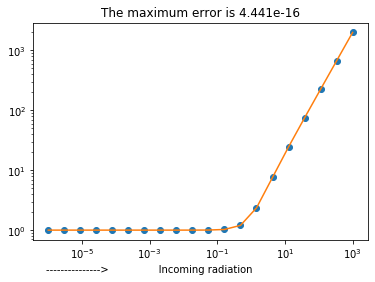

In [4]:
def Iplus_1st(tau,A,B):
    return A + B*(tau-1) + (B-A+1)*np.exp(-tau)

def plus_test(n=20,A=0.5,B=2,solver=integral_1st):
    """ Compute the 1st order numerical solution and compare """
    tau = np.logspace(-6,3,n)
    dtau = np.zeros_like(tau)
    S = np.zeros_like(tau)
    for i in range(n-1):
        dtau[i] = tau[i+1]-tau[i]
        S[i] = A + B*tau[i]
    S[-1] = A + B*tau[-1]
    I_exact = Iplus_1st(tau,A,B)
    I = integral_1st (S, dtau, Ileft=I_exact[0])
    plt.loglog(tau,I,'o')
    plt.loglog(tau,I_exact)
    plt.title('The maximum error is {:.3e}'.format(np.max(np.abs(I/I_exact-1.0))))
    plt.xlabel('--------------->                Incoming radiation                                 ');

plus_test(A=1,B=2,solver=integral_1st)

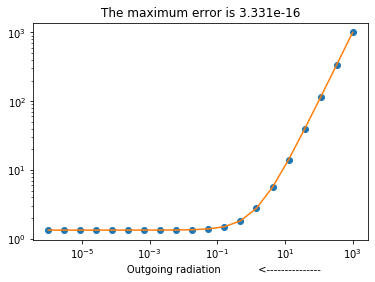

In [5]:
def Iminus_1st(tau,A,B):
    """ Intentionally the wrong exact solution; REPLACE WITH CORRECT SOLUTION """
    return A + B*(tau+1) #

def minus_test(n=20,A=0.5,B=2):
    """ Compute the 1st order numerical solution and compare """
    tau = np.logspace(-6,3,n)
    dtau = np.zeros_like(tau)
    S = np.zeros_like(tau)
    for i in range(n-1):
        dtau[i] = tau[i+1]-tau[i]
        S[i] = A + B*tau[i]
    S[-1] = A + B*tau[-1]
    I_exact = Iminus_1st(tau,A,B)
    I = integral_1st (S, dtau, Iright=I_exact[-1])
    plt.loglog(tau,I,'o')
    plt.loglog(tau,I_exact)
    plt.title('The maximum error is {:.3e}'.format(np.max(np.abs(I/I_exact-1.0))))
    plt.xlabel('               Outgoing radiation            <---------------');
    
minus_test(B=1,A=0.33)

#### Task 2: A 100 stars behind a BE sphere (30p)

Given your radiative transfer solver, imagine that you place for example 100 stars behind a Bonnor-Ebert sphere. Assume that the BE-sphere has a mass of 1 solar mass and a temperature of 10 K (which means the BE-radius is about 10,000 AU), and assume an opacity $\kappa = 1$ cm$^2$ per gram.  Then compute the intensity of the light that comes through, and make a nice image! If you would like to try at other wavelengths, use that $\kappa \propto \kappa_0 / \lambda$ is a good approximation, and that the above opacity corresponds to a wavelength of roughly 1 mm.

Use the ```BE_sphere.py``` to set up you core; you can see how it is used in ```BE_sphere.ipynb```.

It's OK to place the stars in a 10x10 pattern, but it of course looks nicer to place the stars randomly (and to use more than 100 of them)!

using CGS units
{'system': <class 'scaling.CGS'>, 'l': 2.996e+17, 'm': 1.989e+33, 't': 2996000000000.0, 'D': 7.396212086078283e-20, 'v': 100000.0, 'P': 7.396212086078283e-10, 'e': 1.989e+43, 'E': 7.396212086078283e-10, 'mu': 2.4, 'T': 290.7394799739262, 'G': 0.04430105807743658, 'Stefan': 5477979.176931791, 'h_P': 1.1119233219288195e-82, 'k_B': 2.018220211161387e-57, 'c': 299790.0}
BE_sphere: m_solar, gamma, T_K= 1.0 1.0001 10.0


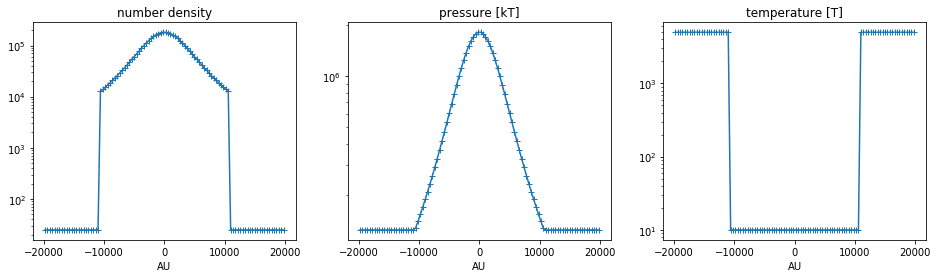

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from BE_sphere import BE_sphere
from scaling   import scaling, CGS
from HD        import HD

class BE_experiment(HD):
    def __init__(u, units, verbose=0, **kwargs):
        HD.__init__(u,**kwargs)
        u.units = units
        BE_sphere(u, verbose=verbose)

units = scaling (l=2e4*CGS.AU, v=CGS.kms, m=CGS.m_Sun, verbose=2)
u = BE_experiment (units, n=100, gamma=1.01, verbose=0)

P = u.E*(u.gamma-1.0)*u.units.P
T = u.T*u.units.T
N = u.D*u.units.D/(u.units.mu*CGS.m_u)
P = P/CGS.k_B

plt.figure(figsize=(16,4))
m = u.n[0]//2
x = u.x*u.units.l/CGS.AU
plt.subplot(1,3,1); plt.semilogy(x,N[:,m,m],'-+'); plt.xlabel('AU'); plt.title('number density');        
plt.subplot(1,3,2); plt.semilogy(x,P[:,m,m],'-+'); plt.xlabel('AU'); plt.title('pressure [kT]');
plt.subplot(1,3,3); plt.semilogy(x,T[:,m,m],'-+'); plt.xlabel('AU'); plt.title('temperature [T]');

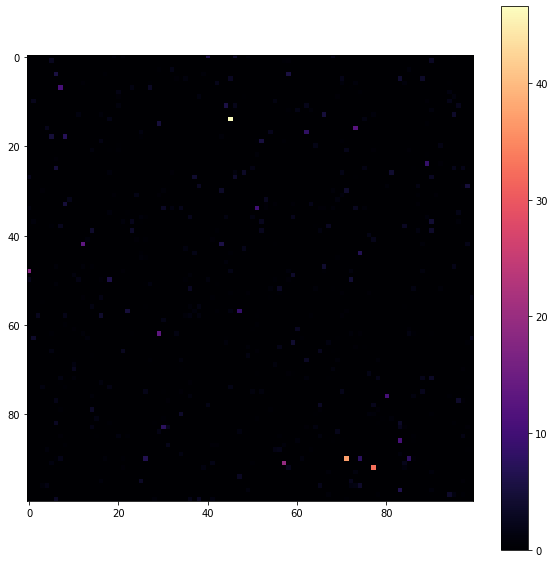

In [7]:
N=500
choices=np.random.lognormal(size=N)
# choices=np.ones(N)
indices=np.random.choice(u.n[0]**2, N)
grid=np.zeros(shape=u.n[0]**2)
grid[indices]=choices
grid=grid.reshape(u.n[:2])
plt.figure(figsize=(10,10))
plt.imshow(grid, cmap='magma')
plt.colorbar()

In [8]:
def BE_solve(BE, I, k=1):
    """ Compute the 1st order numerical solution and compare """
    x=BE.x*BE.units.l
    ds=x[1]-x[0]
    dtau=BE.D*BE.units.D*k*ds
    I=integral_1st(np.zeros_like(dtau), dtau, Ileft=I)
    return I

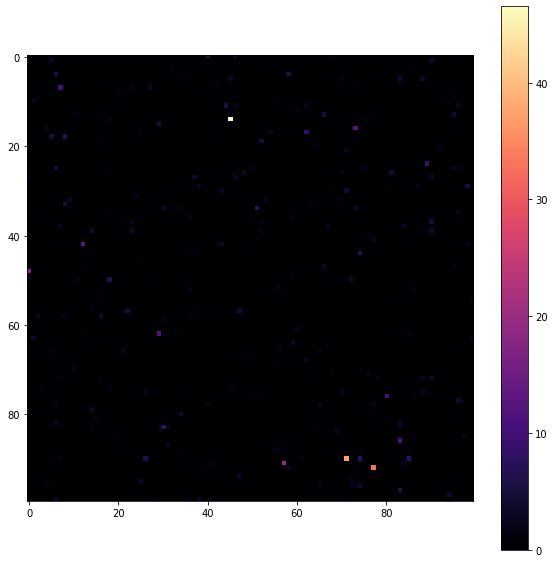

In [9]:
I_final=BE_solve(u, grid, k=10)
plt.figure(figsize=(10,10))
plt.imshow(I_final[99], cmap='magma')
plt.colorbar()
#for 0.1 mm

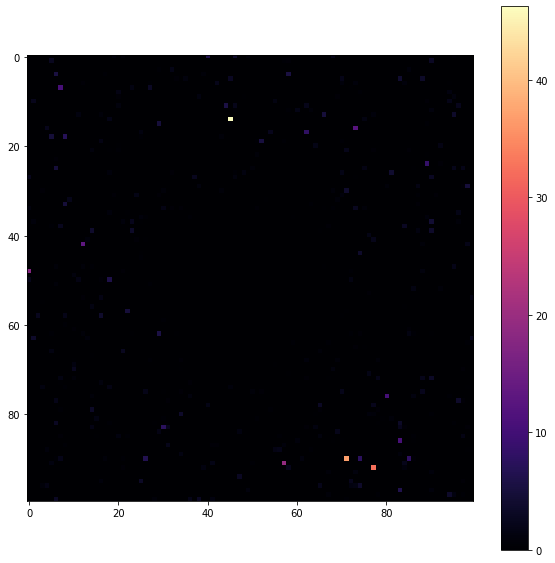

In [10]:
I_final=BE_solve(u, grid, k=100)
plt.figure(figsize=(10,10))
plt.imshow(I_final[99], cmap='magma')
plt.colorbar()
#for 100 micrometer

### 5.2.2  A better integral solver

The simple integral solver above may be sufficient for some purposes.  It requires only that one evaluates one exponential, and a few arithmetic expressions, to compute the three $e$-coefficients that enter into Eq. (18).

However, already in Eq. (13) we learnt that, for accurate work (e.g. when computing heating and cooling) the 2nd derivative of $S$ is important, and hence assuming a linear source function is not enough.  But we can use the results in Eq. 17-19 to get the more accurate solution with no further derivation, by defining 

\begin{equation}\tag{22}
  Q^+ = I^+ - S \,,
\end{equation}

which leads to 

\begin{equation}\tag{23}
\frac{d Q^+}{d \tau} = Q^+ - \frac{d S}{d\tau} =   Q^+ - S'\,.
\end{equation}

This is an equation with exactly the same form as Eq. (5), only with $Q^+$ instead of $I^+$, and $S'$ instead of $S$, and hence for a linear S' (a quadratic S) it has the solution

\begin{equation}\tag{24}
  Q_{i}^+ = Q_{i-1}^+\, e_1 + S'_{i}\, e_4 + S''_{i}\, e_5 \,.
\end{equation}

By expressing the 1st and second derivatives as differences, one can write, now with 2nd order accuracy in $S(\tau)$:

\begin{equation}\tag{25}
  Q_{i}^+ = Q_{i-1}^+\, e_1 + S_{i-1}\, e_6 + S_{i}\, e_7 + S_{i+1}\, e_8 \,.
\end{equation}

#### __Bonus Task: Compute the coefficients needed in the accurate integral RT solver__ (20 p)

Derive, using pen and paper (or symbolic Python, or Mathematic or Maple), expression for $e_{6,7,8}$.  
You will need them below, so be careful, and double check against a known solution!  Start out from

\begin{equation}\tag{26}
  S'_i = \frac{\Delta\tau_{i-1} \Delta S_i/\Delta\tau_i +\Delta\tau_i \Delta S_{i-1}/\Delta\tau_{i-1}}{\frac{1}{2}(\Delta\tau_{i-1}+\Delta\tau_i)}
\end{equation}

\begin{equation}\tag{27}
  S''_i = \frac{\Delta S_i/\Delta\tau_i - \Delta S_{i-1}/\Delta\tau_{i-1} }{\frac{1}{2}(\Delta\tau_{i-1}+\Delta\tau_i)}
\end{equation}

__NOTE:__ we have taken the liberty to redefine slightly, compared to above. $\Delta S_{i-1} \equiv S_i - S_{i-1}$ and both $S'_i$ and $S''_i$ are centered on the same point as $I_i$, $S_i$, and $\tau_i$.

__NOTE:__ It may not be the best and simplest approach to compute long and complicated expression for each of e6, e7, and e8.  They contain common expression, stemming from the implementation of Eqs. 26-27, so computing intermediate expression may actually give fewer operations, and hence faster code!

__PRIZE:__ If you implement the solver, there are 20 extra points, if it is faster than one of my solvers! The test will be made with the `timeit` procedure below, on ERDA, repeating a few times to get a stable average. Naturally, _the code only qualifies to participate if the result is exact_ for a 2nd order source function!

### Python code:

A python code with the accurate integral solver may be written as follows (you need to import your own e6-e8 coefficients!):

In [68]:
# Note that this is Q+
def integral_2nd (S, dtau, Q0):
    Q = np.zeros(S.shape)
    Q[0] = Q0
    ctau = 1.0/dtau
    for i in range(1,S.shape[0]-1):
        ctaui = 2.0/(dtau[i-1]+dtau[i])
        e1 = np.exp(-dtau[i-1])
        e2 = 1.0-e1
        e3 = e1 - e2/dtau[i-1]
        e6 = ctaui/dtau[i-1]*(-e3*(1+dtau[i])+e2)
        e8 = ctaui/dtau[i]*(e3*(1-dtau[i])+e2)
        e7 = -(e6+e8)
        Q[i] = e1*Q[i-1] + e6*S[i-1] + e7*S[i] + e8*S[i+1]
    Q[-1] = e1*Q[-2] + e6*S[-3] + e7*S[-2] + e8*S[-1]
    return Q

In [132]:
# Note that this is Q+
def integral_2nd (S, dtau, Q0):
    Q = np.zeros(S.shape)
    Q[0] = Q0
    ctau = 1.0/dtau
    for i in range(1,S.shape[0]-1):
        if i%50==0:
            print(i)
        ctaui = 2.0/(dtau[i-1]+dtau[i])
        a = np.exp(-dtau[i-1])
        b = 1.0-a
        c = b - a*dtau[i-1]
        ds=S[i+1]-S[i]
        ds1=S[i]-S[i-1]
        S_prime=ctaui*(dtau[i-1]/dtau[i]*ds+dtau[i]/dtau[i-1]*ds1)
        S_dprime=ctaui*(1/dtau[i]*ds-1/dtau[i-1]*ds1)
        Q[i] = (a*Q[i-1] + b*S_prime+c*S_dprime)/2
#     Q[-1] = e1*Q[-2] + e6*S[-3] + e7*S[-2] + e8*S[-1]
    return Q

In [129]:
# Note that this is Q+
def integral_2nd (S, dtau, Q0):
    Q = np.zeros(S.shape)
    Q[0] = Q0
    ctau = 1.0/dtau
    for i in range(1,S.shape[0]-1):
        if i%50==0:
            print(i)
        ctaui = 2.0/(dtau[i-1]+dtau[i])
        e1 = np.exp(-dtau[i-1])
        e2 = 1.0-e1
        e3 = e1 - e2/dtau[i-1]
        e4 = -e3
        e5 = e2+e3
        ds=S[i+1]-S[i]
        ds1=S[i]-S[i-1]
        S_prime=ctaui*(dtau[i-1]/dtau[i]*ds+dtau[i]/dtau[i-1]*ds1)
        S_dprime=ctaui*(1/dtau[i]*ds-1/dtau[i-1]*ds1)
        Q[i] = e1*Q[i-1] + e4*S_prime+e5*S_dprime
    Q[-1] = e1*Q[-2] + e6*S[-3] + e7*S[-2] + e8*S[-1]
    return Q

For reasons unknown -- but presumably because the virtual machine does not get full attention -- the time for a solution varies signficantly, but typically has a well defined bottom, showing up at least some time during 40 attempts.

In [133]:
from time import time
import numpy as np
def timeit(solver=integral_2nd,nit=40):
    n = 200
    S = np.ones((n,n,n))
    dtau = np.ones((n,n,n))
    Q0 = np.ones((n,n))    
    def test(solver):
        t = time()
        Q = solver (S, dtau, Q0)
        used = time()-t
        return 1e9*used/n**3
    start = time()
    worst = test(solver)
    best = worst
    for it in range(nit):
        mus = test(solver)
        if mus < best:
            best = mus
        if mus > worst:
            worst = mus
        plt.plot(it,mus,'o')
    plt.ylim(0,worst*1.1)
    print('{}: {:.2f} seconds =>  {:.1f} nanoseconds per point'.format(solver.__name__,time()-start,best))

/opt/conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


50


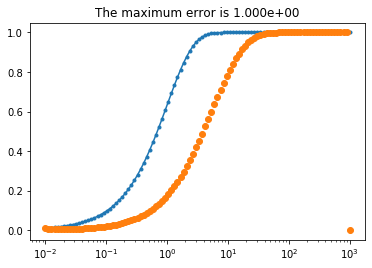

In [134]:
def Q_test(n=100,A=0.5,B=2, C=1):
    """ Compute the 2nd order numerical solution and compare """
    tau = np.logspace(-2, 3,n)
    dtau = np.zeros_like(tau)
    S = np.zeros_like(tau)
    for i in range(n-1):
        dtau[i] = tau[i+1]-tau[i]
        S[i] = A + B*tau[i] + C*tau[i]**2
    S[-1] = A + B*tau[-1] + C*tau[-1]**2

    Q_exact = B+2*C*(tau-1) - np.exp(-tau) 
    Q = integral_2nd(S, dtau, Q0=Q_exact[0])
#     assert np.all(np.isclose(Q_exact, Q))
    plt.plot(tau, Q_exact, '.-')
    plt.plot(tau, Q, 'o')    
    plt.xscale('log')
    plt.title('The maximum error is {:.3e}'.format(np.max(np.abs(Q/Q_exact-1.0))))
Q_test(A=0.5, B=1, C=0)

integral_1st: 12.08 seconds =>  36.3 nanoseconds per point


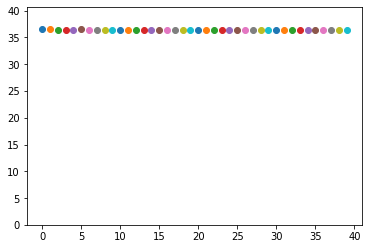

In [48]:
timeit(integral_1st)

integral_2nd: 16.37 seconds =>  49.4 nanoseconds per point


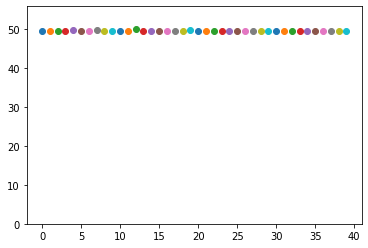

In [49]:
timeit(integral_2nd)

## Absalon Handin:

Copy the solution to task 1, task 2, and possibly the bonus task down here. This gives you a clean reference code above, and makes it easier to see what has been modified.

Submit notebook and pdf of notebook to Absalon

In the first exercise there is a sign error in eq. 16

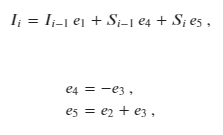

Since if one tries to obtain eq. 18

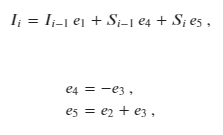

e5!= e2+e3 but = e2-e3, and e4=e3

This can be seen by expanding eq 16

\begin{equation}\tag{16}
  I_{i} = I_{i-1}\, e_1 + S_i \, e_2 - S'_{i}\Delta\tau_{i-1}\, e_3 \,,
\end{equation}

or, since $S'_{i} = (S_i - S_{i-1})/\Delta\tau_{i-1}$, 

\begin{equation}\tag{16}
  I_{i} = I_{i-1}\, e_1 + S_i \, e_2 - (S_{i}-S_{i-1})\, e_3 \,= I_{i-1}\, e_1 + S_i \, (e_2-e_3) + S_{i-1}\, e_3 \-
\end{equation}

\begin{equation}\tag{18}
  I_{i} = I_{i-1}\, e_1 + S_{i-1}\, e_4 + S_{i}\, e_5 \,,
\end{equation}

where

\begin{align}
  e_4 &= e_3 \,,\\  \tag{19}
  e_5 &= e_2 - e_3 \,,
\end{align}

I suppose since the code still works that the error is in eq. 16, i.e. the real solution is

\begin{equation}\tag{16}
  I_{i} = I_{i-1}\, e_1 + S_i \, e_2 + S'_{i}\Delta\tau_{i-1}\, e_3 \,,
\end{equation}

Anyway, here are the real cells. While the answers are fairly obvious, the I- case is especially nice because we can use the identity I goes to S(tau+1), but in reverse because it is I- which I really liked

### Testing the solver on a case with known solution

A simpe linear source function is

\begin{equation}\tag{22}
  S(\tau) = A + B \tau \,,
\end{equation}


#### __Task 1: Construct a test__ (10 p)

Use pen and paper (or overkill with a symbolic code) to solve Eq. (22), and use the solution to test the 1st order solver (or to test your test ;-):

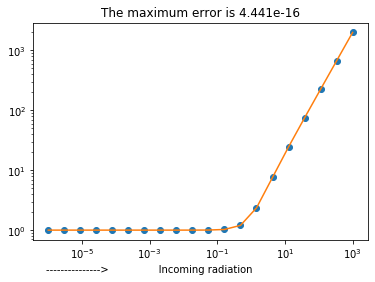

In [4]:
def Iplus_1st(tau,A,B):
    return A + B*(tau-1) + (B-A+1)*np.exp(-tau)

def plus_test(n=20,A=0.5,B=2,solver=integral_1st):
    """ Compute the 1st order numerical solution and compare """
    tau = np.logspace(-6,3,n)
    dtau = np.zeros_like(tau)
    S = np.zeros_like(tau)
    for i in range(n-1):
        dtau[i] = tau[i+1]-tau[i]
        S[i] = A + B*tau[i]
    S[-1] = A + B*tau[-1]
    I_exact = Iplus_1st(tau,A,B)
    I = integral_1st (S, dtau, Ileft=I_exact[0])
    plt.loglog(tau,I,'o')
    plt.loglog(tau,I_exact)
    plt.title('The maximum error is {:.3e}'.format(np.max(np.abs(I/I_exact-1.0))))
    plt.xlabel('--------------->                Incoming radiation                                 ');

plus_test(A=1,B=2,solver=integral_1st)

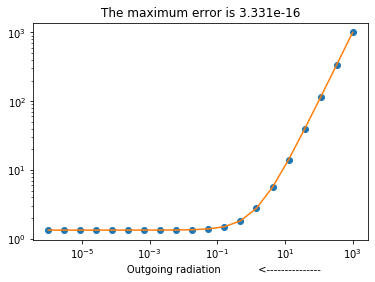

In [5]:
def Iminus_1st(tau,A,B):
    """ Intentionally the wrong exact solution; REPLACE WITH CORRECT SOLUTION """
    return A + B*(tau+1) #

def minus_test(n=20,A=0.5,B=2):
    """ Compute the 1st order numerical solution and compare """
    tau = np.logspace(-6,3,n)
    dtau = np.zeros_like(tau)
    S = np.zeros_like(tau)
    for i in range(n-1):
        dtau[i] = tau[i+1]-tau[i]
        S[i] = A + B*tau[i]
    S[-1] = A + B*tau[-1]
    I_exact = Iminus_1st(tau,A,B)
    I = integral_1st (S, dtau, Iright=I_exact[-1])
    plt.loglog(tau,I,'o')
    plt.loglog(tau,I_exact)
    plt.title('The maximum error is {:.3e}'.format(np.max(np.abs(I/I_exact-1.0))))
    plt.xlabel('               Outgoing radiation            <---------------');
    
minus_test(B=1,A=0.33)

For task 2 I placed different stars at random, just so that it would look like a real starry sky

using CGS units
{'system': <class 'scaling.CGS'>, 'l': 2.996e+17, 'm': 1.989e+33, 't': 2996000000000.0, 'D': 7.396212086078283e-20, 'v': 100000.0, 'P': 7.396212086078283e-10, 'e': 1.989e+43, 'E': 7.396212086078283e-10, 'mu': 2.4, 'T': 290.7394799739262, 'G': 0.04430105807743658, 'Stefan': 5477979.176931791, 'h_P': 1.1119233219288195e-82, 'k_B': 2.018220211161387e-57, 'c': 299790.0}
BE_sphere: m_solar, gamma, T_K= 1.0 1.0001 10.0


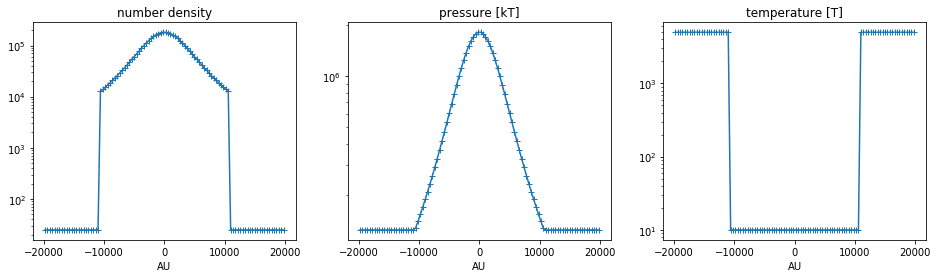

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from BE_sphere import BE_sphere
from scaling   import scaling, CGS
from HD        import HD

class BE_experiment(HD):
    def __init__(u, units, verbose=0, **kwargs):
        HD.__init__(u,**kwargs)
        u.units = units
        BE_sphere(u, verbose=verbose)

units = scaling (l=2e4*CGS.AU, v=CGS.kms, m=CGS.m_Sun, verbose=2)
u = BE_experiment (units, n=100, gamma=1.01, verbose=0)

P = u.E*(u.gamma-1.0)*u.units.P
T = u.T*u.units.T
N = u.D*u.units.D/(u.units.mu*CGS.m_u)
P = P/CGS.k_B

plt.figure(figsize=(16,4))
m = u.n[0]//2
x = u.x*u.units.l/CGS.AU
plt.subplot(1,3,1); plt.semilogy(x,N[:,m,m],'-+'); plt.xlabel('AU'); plt.title('number density');        
plt.subplot(1,3,2); plt.semilogy(x,P[:,m,m],'-+'); plt.xlabel('AU'); plt.title('pressure [kT]');
plt.subplot(1,3,3); plt.semilogy(x,T[:,m,m],'-+'); plt.xlabel('AU'); plt.title('temperature [T]');

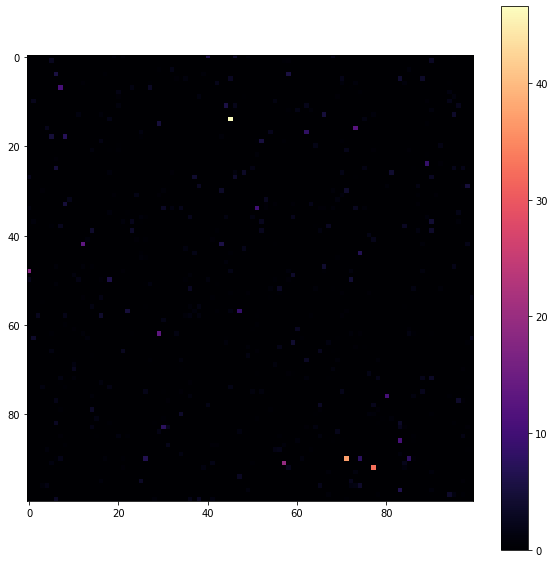

In [7]:
N=500
choices=np.random.lognormal(size=N)
# choices=np.ones(N)
indices=np.random.choice(u.n[0]**2, N)
grid=np.zeros(shape=u.n[0]**2)
grid[indices]=choices
grid=grid.reshape(u.n[:2])
plt.figure(figsize=(10,10))
plt.imshow(grid, cmap='magma')
plt.colorbar()

In [8]:
def BE_solve(BE, I, k=1):
    """ Compute the 1st order numerical solution and compare """
    x=BE.x*BE.units.l
    ds=x[1]-x[0]
    dtau=BE.D*BE.units.D*k*ds
    I=integral_1st(np.zeros_like(dtau), dtau, Ileft=I)
    return I

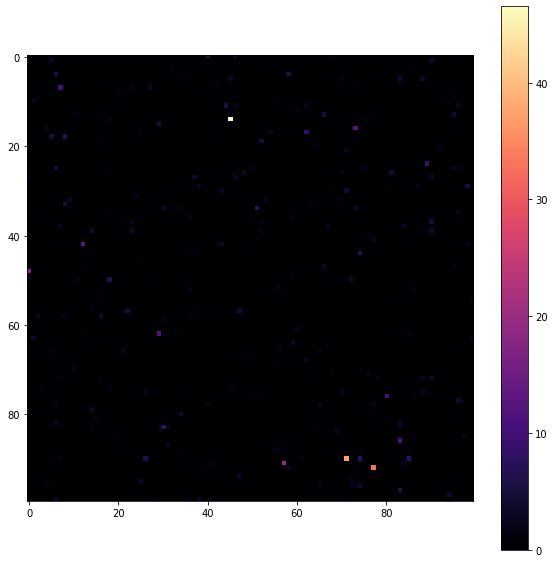

In [9]:
I_final=BE_solve(u, grid, k=10)
plt.figure(figsize=(10,10))
plt.imshow(I_final[99], cmap='magma')
plt.colorbar()
#for 0.1 mm

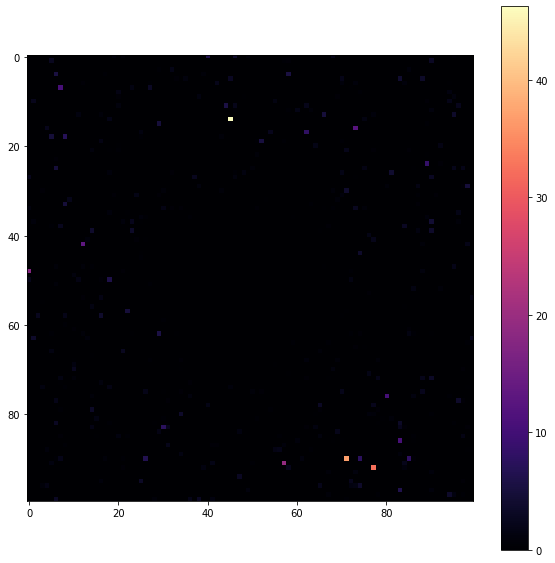

In [10]:
I_final=BE_solve(u, grid, k=100)
plt.figure(figsize=(10,10))
plt.imshow(I_final[99], cmap='magma')
plt.colorbar()
#for 100 micrometer

We clearly see the BE-sphere block out the background at high k, but we do have to go to pretty high k

For the extra task, you have some stuff looped compared to the extra note on the solution on absalon. Here you define:

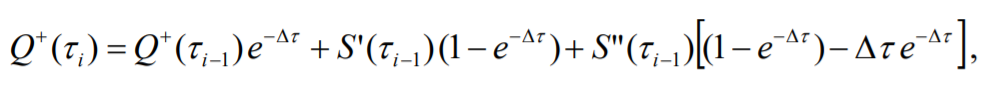

But this has the S' attached to a factor of e2, not e4, whereas the factor on S'' is very different from e5.

This may be because the intent was to do a derivation from the bottom up, but neither really works. I tried for the better part of an entire day, and all of these just go in different directions all the time.

The reason for why I suspect that something is just plain wrong, is because I tried going back and just writing out the full solution with the derivative but that does not seem to work either so I think that there is something wrong with the equations

You can see all the different tries above, I am too tired now, where a lot of algebra, tears and blood were expended, and I hope that I can at least get a few pity points and I'll be looking forward to seeing the real solution. I tried flipping signs and folving it bottom up but nothing works.